In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from src.utils import visualize_metrics

In [2]:
# Reading the data
training = pd.read_csv('data_anno/training_data_crops.csv', sep=',')
X_train = training[training.columns[:-1]]
y_train = training[training.columns[-1]]

testing = pd.read_csv('data_anno/testing_data_crops.csv', sep=',')
X_test = testing[training.columns[:-1]]
y_test = testing[training.columns[-1]]


#Oversampling
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

Random Forest Classifier

In [3]:
clf_balanced = RandomForestClassifier(
    max_depth=5, random_state=0, n_estimators=1000);
clf_balanced.fit(X_res, y_res);

print('Balanced Dataset')
visualize_metrics(clf_balanced, X_test, y_test, params=0, i=0)

Neural Network

In [16]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, accuracy_score
from IPython.display import clear_output 

# Training a neural network using warm start and loops to extract information on specific epochs
clf = MLPClassifier(hidden_layer_sizes=(124,64, 32,8), random_state=42, max_iter=5, early_stopping=True, warm_start=True)
train_loss = []
val_precision = []
val_accuracy = []

for i in range(5, 100, 5):
    clf.fit(X_res, y_res)
    clear_output(wait=True)

    print(f'Epoch {i} metrics:')
    print(f'Training loss: {clf.loss_}')
    print(f"Validation precision: {precision_score(y_test, clf.predict(X_test), average='macro')}")
    print(f"Validation accuracy: {accuracy_score(y_test, clf.predict(X_test))}")

    train_loss.append(clf.loss_)
    val_precision.append(precision_score(y_test, clf.predict(X_test), average='macro'))
    val_accuracy.append(accuracy_score(y_test, clf.predict(X_test)))



training loss at epoch 95
0.024634152964795382
validation precision 95
0.26624004128993634


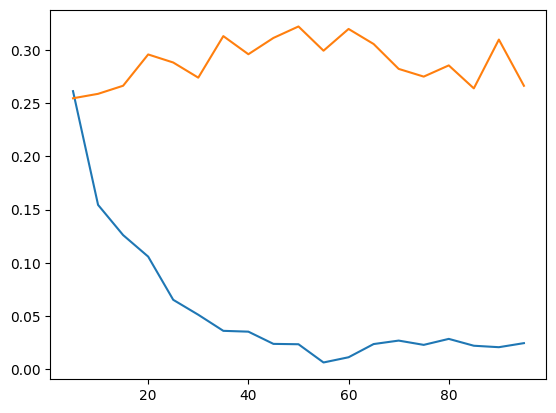

Accuracy: 0.7792096219931272 
Precision: 0.26624004128993634 
Recall: 0.26064283358859003 
F1 Score: 0.25792736725756943


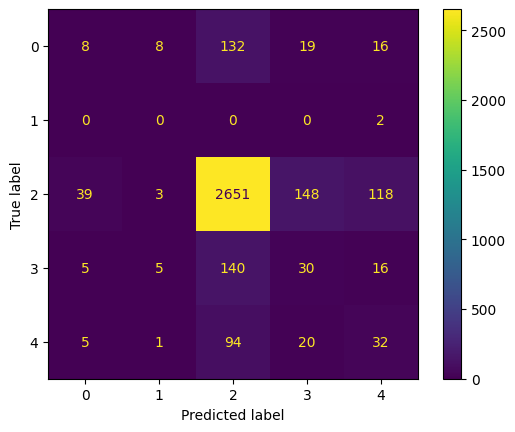

In [17]:
from matplotlib import pyplot as plt

plt.plot([*range(5, 100, 5)], train_loss)
plt.plot([*range(5, 100, 5)], val_precision)
plt.show()

visualize_metrics(clf, X_test, y_test, params=0, i=0)

c:\Users\vismi\Documents\University\7th Semester\Semester Project\ce7_741_HOI_detection\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.7855097365406644 
Precision: 0.30039729190171666 
Recall: 0.26277640035880406 
F1 Score: 0.26701600885359594


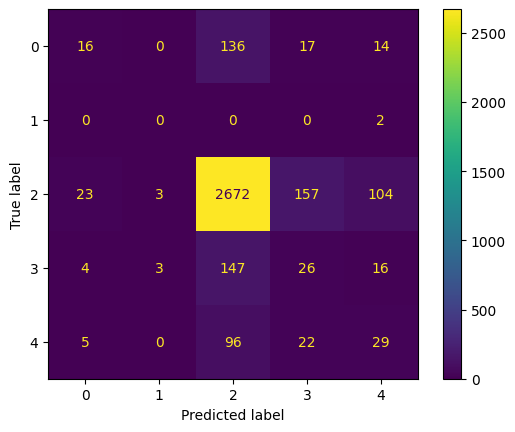

In [18]:
clf = MLPClassifier(hidden_layer_sizes=(124,64, 32,8), random_state=42, max_iter=50, early_stopping=True)
clf.fit(X_res, y_res)
visualize_metrics(clf, X_test, y_test, params=0, i=0)